In [8]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import source.selection_criteria as sc
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/runburg/github/agn_lf


In [11]:
xmmlss = fits.open('./data/XMM-LSS_20190328.fits')

In [14]:
xmmlss[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                 3394 / width of table in bytes                        
NAXIS2  =              8705837 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                  475 / number of columns                              
EXTNAME = './data/tiles/xmm-lss_20190328_0.fits' / table name                   
TTYPE1  = 'help_id '           / label for column 1                             
TFORM1  = '27A     '           / format for column 1                            
TTYPE2  = 'field   '           / label for column 2                             
TFORM2  = '18A     '        

In [9]:
# catalog = table.Table.read('./data/SWIRE_and_XSERVS.fits')
file = './data/master_catalogue_xmm-lss_20180221_photoz_20180518_r_optimised.fits'
catalog = table.Table.read(file)
print(len(catalog))
catalog[0]


6152920


help_id,RA,DEC,id,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,za_hb,chi_r_eazy,chi_r_atlas,chi_r_cosmos,chi_r_stellar,stellar_type
bytes27,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6
HELP_J020942.239-050256.966,32.4259959475648,-5.049157158297614,1,1.0759,0.371,1.8136,0.796,-99.0,-99.0,-99.0,-99.0,1.017680534872741,-99.0,-99.0,-99.0,-99.0,


In [10]:
flux36 = 'F_CH1'
flux45 = 'F_CH2'
flux58 = 'flux_ap2_58'
flux80 = 'flux_ap2_80'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0)
fig, axs = sc.plot_wedge(catalog[never_nan], flux36, flux45, flux58, flux80, selection=['lacy05', 'stern05', 'donley12'])
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')

KeyError: 'flux_ap2_58'

detection80 = np.nan_to_num(catalog[flux80], nan=-99) > 0
plt.scatter(catalog[detection80]['RA_1'], catalog[detection80]['DEC_1'], s=1, alpha=0.1)

In [4]:
print(np.sum(never_nan), len(selected_agn))
ct_lacy = catalog[never_nan][selected_agn]

10743 10743


In [5]:
cosmo = af.setup_cosmology()
print(len(ct_lacy))

ct_lacy = ct_lacy[(ct_lacy['z_eazy'] > 0 ) | (ct_lacy['zSpec'] > 0)]
# ct_lacy = ct_lacy[ct_lacy['z_eazy'] > 0]
print(len(ct_lacy))

import astropy.units as u

spectral_index = 1.5

# unit conversion: ujansky -> jansky: 1e-6
# jansky -> erg / s / cm**2 / Hz: 1e-23
# erg / s / Hz -> erg / s: nu = c/lambda = 3e8 / 3.6e-6
unit_conversion = 1e-6 * 1e-23 * 3e8 / 3.6e-6 * (3.086e24)**2
unit_conversion = 3 / 3.6 * 3.086**2 * 1e33
# print(unit_conversion)

z = np.array([row['zSpec'] if row['zSpec'] > 0 else row['z_eazy'] for row in ct_lacy])
# z = ct_lacy['z_eazy']
ldist = cosmo.luminosity_distance(z).value**2
# print(ldist)
l = 4 * np.pi * cosmo.luminosity_distance(z).value**2 * ct_lacy[flux58] * unit_conversion / (1 + z)**(1 + spectral_index)
# print(l)
print(np.log10(l))

3062
3062
   flux_ap2_58    
       ujy        
------------------
45.373812040319244
 45.28034487258627
 44.01868253753552
  42.7870814320132
 43.63627892559334
 44.09689893465355
 44.96583830375251
 42.80698458719438
 43.31620576510691
 44.04310449390178
               ...
 44.00611820189682
 44.00773148852619
43.970574911399254
 44.33942904312326
 43.77282650173236
44.064688353522016
45.662974763947496
43.859931642027654
 44.03693818095571
43.648314014568626
Length = 3062 rows


/usr/local/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [6]:
print(min(l), max(l), min(z), max(z))
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46

good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
l = l[good_redshift_and_l_selected]
z = z[good_redshift_and_l_selected]
print(len(z))

6.379742446497051e+40 9.529801789545546e+47 0.02 7.7797
2434


[0.48861861 0.61877899 0.78361206 0.9923541  1.25670175 1.5914675
 2.01540963 2.55228333 3.2321718  4.09317197]


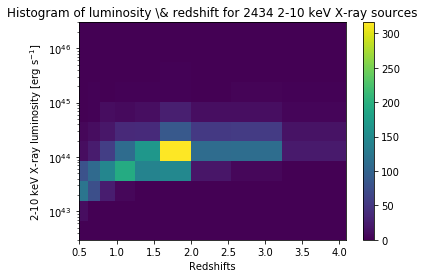

In [7]:
num_bins_z = 10
num_bins_l = 12
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min)-0.01, np.log10(z_sample_max)+0.01, num=num_bins_z)
print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

# print(len(z))
fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='2-10 keV X-ray', unit=r'erg s$^{-1}$')

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.333333  -4.5  
CRPIX : 9450.500101  9850.500106  
NAXIS : 4800  5000


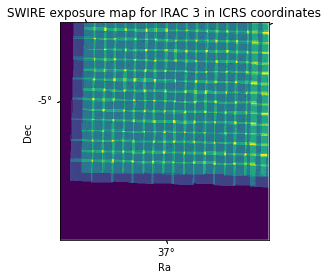

In [8]:
image_file = './data/swire_XMM_I3_tile_1_1_v4_cov.fits'
wcs, hdu = utils.load_wcs(image_file)
fig, ax = vmax.exposure_plot(wcs, hdu.data, survey='SWIRE', band='IRAC 3')

In [24]:
# flux_limit = 5 * unit_conversion
flux_limit = 3631 * 10**(23/-2.5) * 5.8e-6 / 3e8
print(flux_limit)
zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5)
zmin = np.array([0]*len(zmax))

full_fluxes = catalog[never_nan][flux58]
# print(len(full_fluxes), len(ct_lacy), len(good_redshift_and_l_selected))
coverage_correction = vmax.coverage_correction(full_fluxes, ct_lacy[flux58][good_redshift_and_l_selected])

# image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
# wcs, hdu = utils.load_wcs(image_file)
# cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9)

def cov_func(l, z): 
    flux = l / (4 * np.pi * cosmo.luminosity_distance(z).value**2)
# #     print(flux[0, 0], cov_function(flux[0, 0]))
    return 4.8 * coverage_correction(flux / unit_conversion)

print('here')
vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=cov_func)

4.429278494427998e-20
here


In [25]:
zs = (z_bins[:-1]+z_bins[1:])/2
l_limits = 4 * np.pi * cosmo.luminosity_distance(zs).to(u.cm).value**2 * flux_limit / (1 + zs)**(1 + spectral_index)
print(l_limits)
lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)

[1.92020570e+37 2.70986523e+37 3.71903859e+37 4.94588715e+37
 6.35617645e+37 7.88185441e+37 9.42966639e+37 1.08974354e+38
 1.21919826e+38]


In [26]:
lit_data = {}
hz_convert = 5.8e-6 / 3e8
import importlib
importlib.reload(af)

lacy_ir_evol_params_central = {'A': 10**-4.75, 
                               'gamma1':1.07, 
                               'gamma2':2.48,
                               'Lstar': 10**31.92 / hz_convert,
                               'zref':2.5,
                               'k1':1.05,
                               'k2':-4.71,
                               'k3':-0.034
                              }
lacy_ir_evol_params_max = {'A': 10**-4.73, 
                               'gamma1':1.13, 
                               'gamma2':2.53,
                               'Lstar': 10**31.94 / hz_convert,
                               'zref':2.5,
                               'k1':1.08,
                               'k2':-4.58,
                               'k3':0.156
                              }
lacy_ir_evol_params_min = {'A': 10**-4.77, 
                               'gamma1':1.01, 
                               'gamma2':2.43,
                               'Lstar': 10**31.9 / hz_convert,
                               'zref':2.5,
                               'k1':1.02,
                               'k2':-4.84,
                               'k3':-0.224
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 46.2, num=50)
lacy_mid = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_central)
lacy_high = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_max)
lacy_low = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_min)
# print(lacy_mid[0])
lit_data['Lacy 2015'] = list(zip(lacy_mid, lacy_high, lacy_low))
# lacy_mid[1][:10]

array([[1.00000000e+43, 1.66473916e-03],
       [1.16226758e+43, 1.41648259e-03],
       [1.35086592e+43, 1.20507952e-03],
       [1.57006766e+43, 1.02505080e-03],
       [1.82483873e+43, 8.71731622e-04],
       [2.12095089e+43, 7.41150495e-04],
       [2.46511245e+43, 6.29926254e-04],
       [2.86512027e+43, 5.35180376e-04],
       [3.33003639e+43, 4.54462341e-04],
       [3.87039333e+43, 3.85686109e-04]])

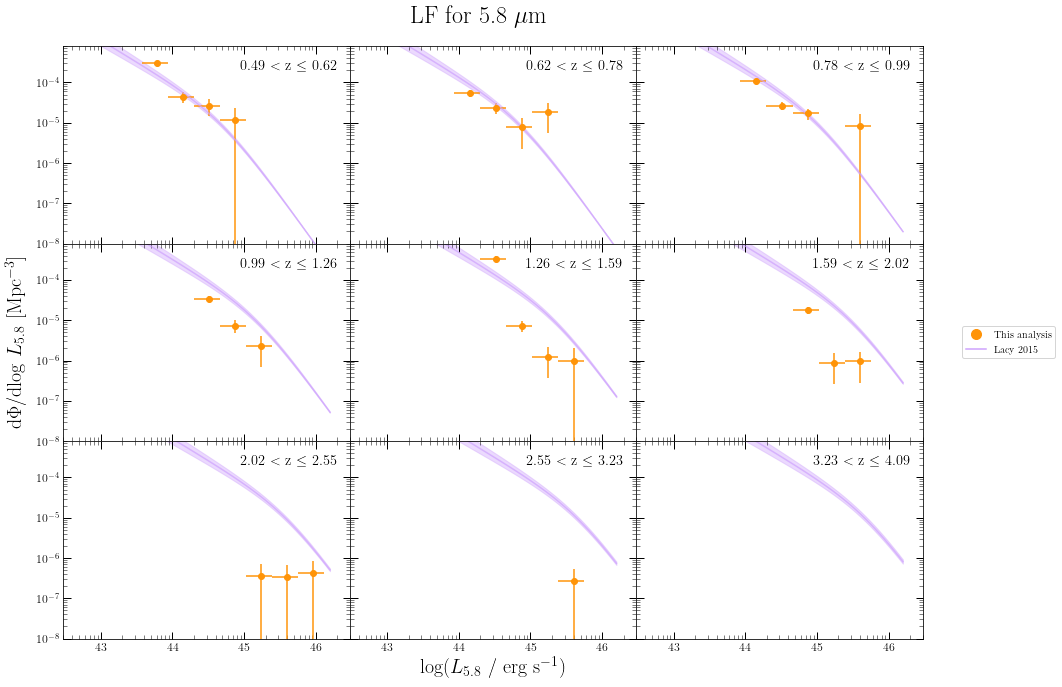

In [27]:
fig, axs, big_ax = vmax.plot_lf_vmax(lf_vals, lf_errs, z_bins, l_bins, \
                                     lum_limits=l_limits, compare_to_others=lit_data, \
                                     title=r'LF for 5.8 $\mu$m', \
                                     outfile='./output/ir_lf.png', lum_sublabel='_{{5.8}}')

In [1]:
from astropy import cosmology

In [6]:
greene = cosmology.LambdaCDM(H0=71, Om0=0.27, Ode0=0.75)
farrah = cosmology.LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
medling = cosmology.LambdaCDM(H0=70, Om0=0.28, Ode0=0.72)

In [7]:
z=1
farrah.luminosity_distance(z)**2/greene.luminosity_distance(z)**2, farrah.luminosity_distance(z)**2/medling.luminosity_distance(z)**2

(<Quantity 0.98335027>, <Quantity 0.97612978>)